##  Creating the DB
This document is solely for testing localy, i am not sure if it can be applied to the current code but i will try my best to make it as compatible as possible

In [34]:
import sqlite3 
import os
import pandas as pd
import re
import unicodedata
import glob

### "Pre processing" the data 
it would be great to have the file path with it in each data frame
(this is nearly identical to what Anna is doing)

In [35]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\farah\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [36]:
df = pd.read_excel('content\ground_truth\data.xlsx')
ground_truth_df = df[['Study_ID', 'Study', 'Allocation', 'Experimenter']]
ground_truth_df

,Study_ID,Study,Allocation,Experimenter
0,1,Chacko et al 2017,Random,Parent
1,1,Chacko et al 2017,Random,Parent
2,2,Coyne et al 2004,Non-random,Teacher
3,2,Coyne et al 2004,Non-random,Teacher
4,3,Purpura et al 2017,Random,Researcher
...,...,...,...,...
311,54,Hassinger-Das (2013),Random,Researcher
312,54,Hassinger-Das (2013),Random,Researcher
313,54,Hassinger-Das (2013),Random,Researcher
314,27,Crandell 2010,Random,Teacher


In [37]:
# extracting data from the csv files in the extracted directory

def extract_df_from_csv(extracted_dir):
    """
    Loads all CSV files from the given directory into a combined DataFrame.
    Args:
        extracted_dir (str): Path to the directory containing CSV files.
    Returns:
        pd.DataFrame: Combined DataFrame of all loaded CSV files.
    """
    extracted_dfs = []
    print(f"Extracting data from CSV files in directory: {extracted_dir}")
    if os.path.exists(extracted_dir):
        for filename in os.listdir(extracted_dir):
            if filename.endswith('.csv'):
                file_path = os.path.join(extracted_dir, filename)
                try:
                    df = pd.read_csv(file_path)
                    extracted_dfs.append(df)
                    #print(f"Loaded {filename}")
                except Exception as e:
                    print(f"Failed to load {filename}: {e}")

    if extracted_dfs:
        extracted_combined_df = pd.concat(extracted_dfs, ignore_index=True)
        print("Combined DataFrame created.")
        print(f"Total rows in combined DataFrame: {len(extracted_combined_df)}")
        print("-"* 40)
        return extracted_combined_df
    else:
        print("No CSV files found in the directory.")
        return pd.DataFrame()

In [38]:
def extract_data_from_csv_in_dir(ext_splitted = [], directory='content/extracted_*'):
    # Get all directory names matching the pattern
    ext_splitted_dir = [d for d in glob.glob(directory) if os.path.isdir(d)]

    for dir in ext_splitted_dir:
        if os.path.exists(dir):
            print(f"Extracted data from {dir}")
            ext_splitted.append({'dir': dir, 'data': extract_df_from_csv(dir)})

In [39]:
ext_splitted = []
extract_data_from_csv_in_dir(ext_splitted, directory='content/extracted_*')

extracted_combined_df = extract_df_from_csv('content/extracted')

Extracted data from content\extracted_split_1_shuffle_1
Extracting data from CSV files in directory: content\extracted_split_1_shuffle_1
Combined DataFrame created.
Total rows in combined DataFrame: 18
----------------------------------------
Extracted data from content\extracted_split_1_shuffle_2
Extracting data from CSV files in directory: content\extracted_split_1_shuffle_2
Combined DataFrame created.
Total rows in combined DataFrame: 18
----------------------------------------
Extracted data from content\extracted_split_2_shuffle_1
Extracting data from CSV files in directory: content\extracted_split_2_shuffle_1
Combined DataFrame created.
Total rows in combined DataFrame: 17
----------------------------------------
Extracted data from content\extracted_split_2_shuffle_2
Extracting data from CSV files in directory: content\extracted_split_2_shuffle_2
Combined DataFrame created.
Total rows in combined DataFrame: 17
----------------------------------------
Extracted data from content\

In [44]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

def format_studyName(study_name_string):
    """
    Cuts a string after the last four-digit number, assuming it represents the year.

    Args:
        study_name_string (str): The input string potentially containing a year.

    Returns:
        str: The string cut after the year, or the original string if no year is found.
    """
    # Get rid of all the points, -
    study_name_string = study_name_string.replace('.', '')
    study_name_string = study_name_string.replace(',', '')
    study_name_string = study_name_string.replace(' - ', ' ')
    study_name_string = study_name_string.replace(')', '')
    study_name_string = study_name_string.replace('(', '')
    study_name_string = study_name_string.replace('&', 'and')
    study_name_string = remove_accents(study_name_string)
    # Find all occurrences of four consecutive digits (potential years)
    year_matches = list(re.finditer(r'\b\d{4}\b', study_name_string))

    if year_matches:
        # Get the last match
        last_year_match = year_matches[-1]
        # Get the end index of the last year match
        end_of_year_index = last_year_match.end()
        # Slice the string up to the end of the year
        cut_string = study_name_string[:end_of_year_index]
        return cut_string.strip() # Use strip to remove trailing whitespace
    else:
        # If no four-digit number is found, return the original string
        return study_name_string.strip()
    
def accuracy_check(col_name, df_extracted, test_table):
  allocation_match = False
  experimenter_match = False

  # Check if both dataframes have the expected columns and rows
  if col_name in df_extracted.columns and \
    not df_extracted.empty and not test_table.empty:

      extracted_allocation = df_extracted[col_name].iloc[0]

      ground_truth_allocation = test_table[col_name].iloc[0]

      # Simple case-insensitive comparison
      if str(extracted_allocation).lower() == str(ground_truth_allocation).lower():
          allocation_match = True
          #print(f'{col_name}: Match')
      else:
          print(f"{col_name}: Mismatch (Extracted: '{extracted_allocation}', Ground Truth: '{ground_truth_allocation}')")
  else:
    print("Cannot perform accuracy check: Extracted or ground truth data is missing or malformed.")
  print("--------------------")

In [ ]:
def format_name_and_accuracy_check(ext_splitted, ground_truth_df):
    for ext in ext_splitted:
        ext['data']['Study'] = ext['data']['Study'].apply(format_studyName)
        print(f"Formatted Study names in {ext['dir']}")
        accuracyCheck_alloc_and_exp(ext['data'], ground_truth_df)
        #accuracy_check('Allocation', ext['data'], ground_truth_df)
        #accuracy_check('Experimenter', ext['data'], ground_truth_df)

def accuracyCheck_alloc_and_exp(extracted_combined_df, ground_truth_df):
    accuracy_check('Allocation', extracted_combined_df, ground_truth_df)
    accuracy_check('Experimenter', extracted_combined_df, ground_truth_df)

Extracted data from content\extracted_split_1_shuffle_1
Extracting data from CSV files in directory: content\extracted_split_1_shuffle_1
Combined DataFrame created.
Total rows in combined DataFrame: 18
----------------------------------------
Extracted data from content\extracted_split_1_shuffle_2
Extracting data from CSV files in directory: content\extracted_split_1_shuffle_2
Combined DataFrame created.
Total rows in combined DataFrame: 18
----------------------------------------
Extracted data from content\extracted_split_2_shuffle_1
Extracting data from CSV files in directory: content\extracted_split_2_shuffle_1
Combined DataFrame created.
Total rows in combined DataFrame: 17
----------------------------------------
Extracted data from content\extracted_split_2_shuffle_2
Extracting data from CSV files in directory: content\extracted_split_2_shuffle_2
Combined DataFrame created.
Total rows in combined DataFrame: 17
----------------------------------------
Extracted data from content\

In [ ]:
ext_splitted = []
extract_data_from_csv_in_dir(ext_splitted, directory='content/extracted_*')

format_name_and_accuracy_check(ext_splitted, ground_truth_df)
accuracyCheck_alloc_and_exp(extracted_combined_df, ground_truth_df)

Formatted Study names in content\extracted_split_1_shuffle_1
--------------------
Experimenter: Mismatch (Extracted: 'Researcher', Ground Truth: 'Parent')
--------------------
Formatted Study names in content\extracted_split_1_shuffle_2
--------------------
Experimenter: Mismatch (Extracted: 'Researcher', Ground Truth: 'Parent')
--------------------
Formatted Study names in content\extracted_split_2_shuffle_1
Allocation: Mismatch (Extracted: 'Non-random', Ground Truth: 'Random')
--------------------
Experimenter: Mismatch (Extracted: 'Teacher', Ground Truth: 'Parent')
--------------------
Formatted Study names in content\extracted_split_2_shuffle_2
--------------------
--------------------
Formatted Study names in content\extracted_split_3_shuffle_1
--------------------
Experimenter: Mismatch (Extracted: 'Teacher', Ground Truth: 'Parent')
--------------------
Formatted Study names in content\extracted_split_3_shuffle_2
--------------------
Experimenter: Mismatch (Extracted: 'Researcher

### Loading the dataBase

In [11]:
def creatingDB(gt, extracted, table_nameGt, table_name_extracted):
  '''creates a SQLite database with the same structure as the given DataFrame and inserts the data into it.
  Args:
      gt (DataFrame): The ground truth DataFrame.
      extracted (DataFrame): The extracted DataFrame.
      table_nameGt (str): The name of the table for ground truth data.
      table_name_extracted (str): The name of the table for extracted data.
  '''
  
  # Connect to database
  conn = sqlite3.connect('content/database.db')

  # Dropping the tables if they exist
  conn.execute(f"DROP TABLE IF EXISTS {table_nameGt}")
  conn.execute(f"DROP TABLE IF EXISTS {table_name_extracted}")

  # Automatically create table with same name and structure
  gt.to_sql(table_nameGt, conn, if_exists='append', index=False)
  extracted.to_sql(table_name_extracted, conn, if_exists='append', index=False)

  print(f"Tables {table_nameGt} and {table_name_extracted} created with the same structure as the CSV and data inserted.")
  
  # Done
  conn.commit()
  conn.close()

In [ ]:
### still doesn't work yet 
# TODO : debug function creatingBD_multiSplit
def creatingBD_multiSplit(ext_splitted, ground_truth_df):
    """
    Creates a SQLite database with the same structure as the given DataFrame and inserts the data into it.
    Args:
        ext_splitted (list): List of dictionaries containing extracted data.
        ground_truth_df (DataFrame): The ground truth DataFrame.
    """
    # Connect to database
    conn = sqlite3.connect('content/database.db')

    # Dropping the tables if they exist
    conn.execute("DROP TABLE IF EXISTS GroundTruth")
    for ext in ext_splitted:
        conn.execute(f"DROP TABLE IF EXISTS {ext['dir'].replace('content\extracted_', '')}")

    # Create GroundTruth table
    ground_truth_df.to_sql('GroundTruth', conn, if_exists='append', index=False)

    # Create ExtractedData table for each extracted DataFrame
    for ext in ext_splitted:
        ext['data'].to_sql({ext['dir'].replace('extracted_', '')}, conn, if_exists='append', index=False)
        print(f"Table {ext['dir']} table got created.")

    print("Tables GroundTruth and ExtractedData created with the same structure as the CSV and data inserted.")

    # Done
    conn.commit()
    conn.close()

def inserting_a_single_table_in_DB(conn, df):
    """inserting a single table at a time in the database
        args:
            conn (sqlite3.Connection): The SQLite connection object.
            df (DataFrame): The DataFrame to be inserted into the database.
    """
    #connecting to the database
    conn = sqlite3.connect('content/database.db')

    # Dropping the table if it exists
    conn.execute(f"DROP TABLE IF EXISTS {df[dir].replace('extracted_', '')}")

    # Populating the table with the DataFrame
    df['data'].to_sql(df[dir].replace('extracted_', ''), conn, if_exists='append', index=False)
    print(f"Table {df[dir]} got created.")

    # Done
    conn.commit()
    conn.close()


In [56]:
gt_table = 'Ground_truth'
extracted_table = 'Extracted'
creatingDB(ground_truth_df, extracted_combined_df, gt_table, extracted_table)
#creatingBD_multiSplit(ext_splitted, ground_truth_df)

Tables Ground_truth and Extracted created with the same structure as the CSV and data inserted.


In [57]:
for ext in ext_splitted:
    creatingDB(ground_truth_df, ext['data'], gt_table, os.path.basename(ext['dir']))

Tables Ground_truth and extracted_split_1_shuffle_1 created with the same structure as the CSV and data inserted.
Tables Ground_truth and extracted_split_1_shuffle_2 created with the same structure as the CSV and data inserted.
Tables Ground_truth and extracted_split_2_shuffle_1 created with the same structure as the CSV and data inserted.
Tables Ground_truth and extracted_split_2_shuffle_2 created with the same structure as the CSV and data inserted.
Tables Ground_truth and extracted_split_3_shuffle_1 created with the same structure as the CSV and data inserted.
Tables Ground_truth and extracted_split_3_shuffle_2 created with the same structure as the CSV and data inserted.
Tables Ground_truth and extracted_split_4_shuffle_1 created with the same structure as the CSV and data inserted.
Tables Ground_truth and extracted_split_4_shuffle_2 created with the same structure as the CSV and data inserted.


In [60]:
def print_all_tables_in_db(database='content/database.db'):
    """Prints all tables in the SQLite database."""
    conn = sqlite3.connect(database)
    cursor = conn.cursor()
    # print all tables in the database
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    tables = cursor.fetchall()
    print("Tables in the database:")
    for table in tables:
        print(table[0])
    # Close the connection
    conn.close()

print_all_tables_in_db(database='content/database.db')

Tables in the database:
Extracted
extracted_split_1_shuffle_1
extracted_split_1_shuffle_2
extracted_split_2_shuffle_1
extracted_split_2_shuffle_2
extracted_split_3_shuffle_1
extracted_split_3_shuffle_2
extracted_split_4_shuffle_1
Ground_truth
extracted_split_4_shuffle_2


## Calculating the mesures
Auxilary functions used to calculate the mesures

In [ ]:
def calculateAccuracy(TP, FP, FN, TN):
    '''calculates the accuracy of a model based on true positives, true negatives, false positives, and false negatives.'''
    return TP + TN / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0

def calculatePrecision(TP, FP):
    '''calculates the precision of a model based on true positives and false positives.'''
    return TP / (TP + FP) if (TP + FP) > 0 else 0

def calculateRecall(TP, FN):
    '''calculates the recall of a model based on true positives and false negatives.'''
    return TP / (TP + FN) if (TP + FN) > 0 else 0

def calculateF1Score(precision, recall):
    '''calculates the F1 score based on precision and recall.'''
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

def calculateMesures(TP, FP, FN, TN):
    '''calculates various metrics based on true positives, false positives, and false negatives.'''
    # --- Metrics ---
    accuracy = calculateAccuracy(TP, FP, FN, TN) 
    recall = calculateRecall(TP, FN)
    precision = calculatePrecision(TP, FP)
    f1 = calculateF1Score(precision, recall)

    return {
        'Accuracy': round(accuracy, 4),
        'Recall': round(recall, 4),
        'Precision': round(precision, 4),
        'F1': round(f1, 4)
    }


## SQL queries

In [15]:
def printAllTables(gt_table=gt_table, extracted_table=extracted_table):
    '''affiche toutes les tables de la base de données.'''

    conn = sqlite3.connect('content/database.db')
    cursor = conn.cursor()

    # testing if the data is inserted correctly
    cursor.execute(f"SELECT * FROM {gt_table} LIMIT 15;")
    print("Ground Truth Table:")
    for row in cursor.fetchall():
        print(row)

    cursor.execute(f"SELECT * FROM {extracted_table} ;")
    print("\nExtracted Table:")
    for row in cursor.fetchall():
        print(row)

    conn.commit()
    conn.close()

def countElements():
    '''counts the number of elements in each table and prints the result. -- specific to our database.'''

    conn = sqlite3.connect('content/database.db')
    cursor = conn.cursor()

    # testing if the data is inserted correctly
    cursor.execute(f"SELECT COUNT(DISTINCT Study) FROM {gt_table};")
    print("Ground Truth Table count:")
    print(cursor.fetchall()[0])
        

    cursor.execute(f"SELECT COUNT(DISTINCT Study) FROM {extracted_table} ;")
    print("\nExtracted Table count:")
    print(cursor.fetchall()[0])

    cursor.execute(f"""
        SELECT COUNT(ext.Study)
        FROM {gt_table} AS gt
                JOIN {extracted_table} AS ext ON gt.Study = ext.Study
        """)
    print("Total matched rows:", cursor.fetchone()[0])


    conn.commit()
    conn.close()

countElements()
printAllTables()

Ground Truth Table count:
(54,)

Extracted Table count:
(18,)
Total matched rows: 0
Ground Truth Table:
(1, 'Chacko et al 2017', 'Random', 'Parent')
(1, 'Chacko et al 2017', 'Random', 'Parent')
(2, 'Coyne et al 2004', 'Non-random', 'Teacher')
(2, 'Coyne et al 2004', 'Non-random', 'Teacher')
(3, 'Purpura et al 2017', 'Random', 'Researcher')
(3, 'Purpura et al 2017', 'Random', 'Researcher')
(4, 'Vaknin-Nusbau & Nevo 2017', 'Random', 'Teacher')
(4, 'Vaknin-Nusbau & Nevo 2017', 'Random', 'Teacher')
(4, 'Vaknin-Nusbau & Nevo 2017', 'Random', 'Teacher')
(4, 'Vaknin-Nusbau & Nevo 2017', 'Random', 'Teacher')
(4, 'Vaknin-Nusbau & Nevo 2017', 'Random', 'Teacher')
(4, 'Vaknin-Nusbau & Nevo 2017', 'Random', 'Teacher')
(5, 'Wing-Yin Chow & McBride-Chang 2003', 'Random', 'Parent')
(5, 'Wing-Yin Chow & McBride-Chang 2003', 'Random', 'Parent')
(5, 'Wing-Yin Chow & McBride-Chang 2003', 'Random', 'Parent')

Extracted Table:
('Random', 'Teacher', 'Joint storybook reading and joint writing interventions a

In [16]:
def countElements(table, column):
    '''counts the number of distinct elements in a given column of a table.'''
    
    conn = sqlite3.connect('content/database.db')
    cursor = conn.cursor()

    cursor.execute(f"SELECT COUNT(DISTINCT {column}) FROM {table};")
    count = cursor.fetchone()[0]
    print(f"Number of distinct elements of {column} in {table}: {count}")
    conn.commit()
    conn.close()
    return count

def countRows(table):
    '''counts the number of rows in a given table.'''
    
    conn = sqlite3.connect('content/database.db')
    cursor = conn.cursor()

    cursor.execute(f"SELECT COUNT(*) FROM {table};")
    count = cursor.fetchone()[0]

    conn.commit()
    conn.close()

    return count

elements = countElements(gt_table, 'Study_ID')

numberOfStudies = []
for ext in ext_splitted:
    #countElements(os.path.basename(ext['dir']), 'Study')
    split_name = os.path.basename(ext['dir'])
    numberOfStudies.append((split_name, countRows(split_name)))
    print("Rows in each data set", numberOfStudies[-1])
    #print("Rows in each data set", countRows(os.path.basename(ext['dir'])))



Number of distinct elements of Study_ID in Ground_truth: 54
Rows in each data set ('extracted_split_1_shuffle_1', 18)
Rows in each data set ('extracted_split_1_shuffle_2', 18)
Rows in each data set ('extracted_split_2_shuffle_1', 17)
Rows in each data set ('extracted_split_2_shuffle_2', 17)
Rows in each data set ('extracted_split_3_shuffle_1', 16)
Rows in each data set ('extracted_split_3_shuffle_2', 16)
Rows in each data set ('extracted_split_4_shuffle_1', 15)
Rows in each data set ('extracted_split_4_shuffle_2', 15)


## Mesures

### Mesuring For binary values

In [17]:
def truePositives(conn, gt, extracted, column = 'Allocation', positiveValue = 'Random'):
    '''calculates the number of true positives based on ground truth and extracted data.
        where the ground thruth and extracted data both have the value 'Random'

        Args:
            conn (str): The path to the SQLite database.
            gt (str): The name of the ground truth table.
            extracted (str): The name of the extracted data table.
            column (str): The column to check for the positive value. Default is 'Allocation'.
            positiveValue (str): The value to check for in the specified column. Default is 'Random'.
        Returns:
            int: The count of true positives.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    cursor.execute(f"""
        SELECT COUNT(*) 
        FROM {gt} AS gt 
            JOIN {extracted} AS ext ON gt.Study = ext.Study 
        WHERE gt.{column} = '{positiveValue}' AND ext.{column} = '{positiveValue}'
    """)
    result = cursor.fetchone()
    TP_count = result[0]
    
    print(f"Number of True Positives for '{column}': {TP_count}")

    conn.commit()
    conn.close()
    return TP_count

def falsePositives(conn, gt, extracted, column = 'Allocation', positiveValue = 'Random' ):
    '''calculates the number of true positives based on ground truth and extracted data.
        where gt = Random (1) and extracted (model output) = Non-random (0)
        Args:
            conn (str): The path to the SQLite database.
            gt (str): The name of the ground truth table.
            extracted (str): The name of the extracted data table.
            column (str): The column to check for the positive value. Default is 'Allocation'.
            positiveValue (str): The value to check for in the specified column. Default is 'Random'.
        Returns:
            int: The count of false positives.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    
    cursor.execute(f"""
        SELECT COUNT(*) FROM {gt} AS gt
        JOIN {extracted} AS ext ON gt.Study = ext.Study
        WHERE gt.{column} = '{positiveValue}' AND ext.{column} != '{positiveValue}'
    """)
    result = cursor.fetchone()
    FP_count = result[0]
    
    print(f"Number of false Positives for '{column}': {FP_count}")

    conn.commit()
    conn.close()

    return FP_count

def falseNegatives(conn, gt, extracted, column = 'Allocation', positiveValue = 'Random'):
    '''calculates the number of true positives based on ground truth and extracted data.
        where gt = Non-random (0) and extracted (model output) = Random (1)
        Args:
            conn (str): The path to the SQLite database.
            gt (str): The name of the ground truth table.
            extracted (str): The name of the extracted data table.
            column (str): The column to check for the positive value. Default is 'Allocation'.
            positiveValue (str): The value to check for in the specified column. Default is 'Random'.
        Returns:
            int: The count of false negatives.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    
    cursor.execute(f"""
        SELECT COUNT(*) FROM {gt} AS gt
        JOIN {extracted} AS ext ON gt.Study = ext.Study
        WHERE gt.{column} != '{positiveValue}' AND ext.{column} = '{positiveValue}'
    """)
    result = cursor.fetchone()
    FN_count = result[0]
    
    print(f"Number of false Negatives for '{column}': {FN_count}")

    conn.commit()
    conn.close()

    return FN_count

def trueNegatives(conn, gt, extracted, column = 'Allocation', positiveValue = 'Random'):
    '''calculates the number of true negatives based on ground truth and extracted data.
        where gt = Non-random (0) and extracted (model output) = Non-random (0)
        Args:
            conn (str): The path to the SQLite database.
            gt (str): The name of the ground truth table.
            extracted (str): The name of the extracted data table.
            column (str): The column to check for the positive value. Default is 'Allocation'.
            positiveValue (str): The value to check for in the specified column. Default is 'Random'.
        Returns:
            int: The count of true negatives.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    
    cursor.execute(f"""
        SELECT COUNT(*) FROM {gt} AS gt
        JOIN {extracted} AS ext ON gt.Study = ext.Study
        WHERE gt.{column} != '{positiveValue}' AND ext.{column} != '{positiveValue}'
    """)
    result = cursor.fetchone()
    TN_count = result[0]
    
    print(f"Number of true Negatives for '{column}': {TN_count}")

    conn.commit()
    conn.close()

    return TN_count

In [ ]:
#print("True Positives:")
TP = truePositives('content/database.db', gt_table, extracted_table, 'Allocation')

#print("false Positives:")
FP = falsePositives('content/database.db', gt_table, extracted_table, 'Allocation')

#print("false Negatives:")
FN = falseNegatives('content/database.db', gt_table, extracted_table, 'Allocation')

TN = trueNegatives('content/database.db', gt_table, extracted_table, 'Allocation')

print("Calculating metrics... : \n", calculateMesures(TP, FP, FN))

Number of True Positives for 'Allocation': 0
Number of false Positives for 'Allocation': 0
Number of false Negatives for 'Allocation': 0
Number of true Negatives for 'Allocation': 0
Calculating metrics... : 
 {'Accuracy': 0, 'Recall': 0, 'Precision': 0, 'F1': 0}


In [ ]:
import pandas as pd

def countingMesuresForEveryone(conn, gt, extracted=None, column='Allocation', positiveValue='Random'):
    '''counts the number of true positives, false positives, false negatives, and true negatives for each extracted data set.
        Args:
            conn (str): The path to the SQLite database.
            gt (str): The name of the ground truth table.
            extracted (list): A list of dir names (the names of each table in the data set).
            column (str): The column to check for the positive value. Default is 'Allocation'.
            positiveValue (str): The value to check for in the specified column. Default is 'Random'.
    '''
    results = []
    if extracted is None:
        extracted = [os.path.basename(ext['dir']) for ext in ext_splitted]
    for ext in extracted:
        TP = truePositives(conn, gt, ext, column, positiveValue)
        FP = falsePositives(conn, gt, ext, column, positiveValue)
        FN = falseNegatives(conn, gt, ext, column, positiveValue)
        TN = trueNegatives(conn, gt, ext, column, positiveValue)
        metrics = calculateMesures(TP, FP, FN)
        
        print(f"Metrics for {ext}:")
        #print(metrics)
        results.append({
            'Dataset': ext,
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'TN': TN,
            **metrics
        })

    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

Number of True Positives for 'Allocation': 12
Number of false Positives for 'Allocation': 0
Number of false Negatives for 'Allocation': 19
Number of true Negatives for 'Allocation': 0
Metrics for extracted_split_1_shuffle_1:
Number of True Positives for 'Allocation': 12
Number of false Positives for 'Allocation': 0
Number of false Negatives for 'Allocation': 19
Number of true Negatives for 'Allocation': 0
Metrics for extracted_split_1_shuffle_2:
Number of True Positives for 'Allocation': 0
Number of false Positives for 'Allocation': 12
Number of false Negatives for 'Allocation': 0
Number of true Negatives for 'Allocation': 2
Metrics for extracted_split_2_shuffle_1:
Number of True Positives for 'Allocation': 12
Number of false Positives for 'Allocation': 0
Number of false Negatives for 'Allocation': 19
Number of true Negatives for 'Allocation': 0
Metrics for extracted_split_2_shuffle_2:
Number of True Positives for 'Allocation': 9
Number of false Positives for 'Allocation': 0
Number of 

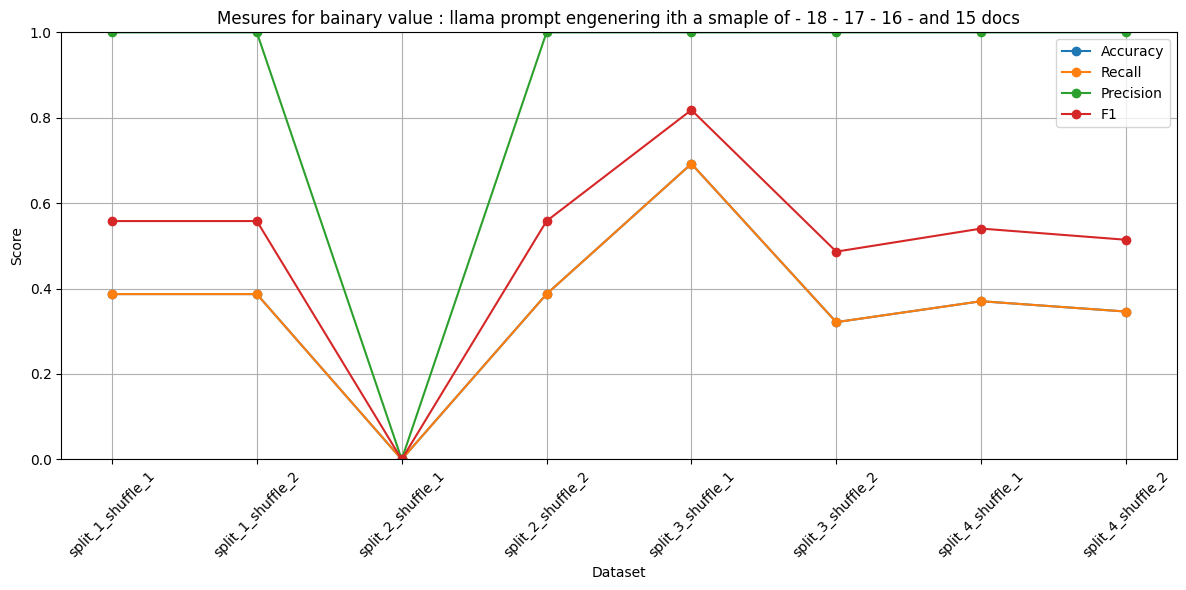

In [20]:
splitted_mesures = countingMesuresForEveryone('content/database.db', gt_table, extracted=None, column='Allocation', positiveValue='Random')

import matplotlib.pyplot as plt

def plot_binary_mesures(splitted_mesures):
    # Clean up dataset names for readability
    splitted_mesures['Cleaned_Dataset'] = splitted_mesures['Dataset'].str.replace('extracted_', '', regex=False)

    metrics = ['Accuracy', 'Recall', 'Precision', 'F1']

    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(splitted_mesures['Cleaned_Dataset'], splitted_mesures[metric], marker='o', label=metric)

    plt.xlabel('Dataset')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title('Mesures for bainary value : llama prompt engenering ith a smaple of - 18 - 17 - 16 - and 15 docs')
    plt.grid() 
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_binary_mesures(splitted_mesures)

### Multi class values 
Exparimenter
Basically it's when the selected column can be more then 2 values (non binary), i think it can work with allocation (binary values) but i still did a separate case for it just in case

In [21]:
def truePositivesExperimenter(conn, gt, extracted, column = 'Experimenter', 
                              values = ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent']):
    
    '''calculates the number of true positives based on ground truth and extracted data.
        where the ground thruth and extracted data both have the value 'teacher', 'parent', 'researcher' or 'Combined - Teacher and Parent'
    Args:
        conn (str): The path to the SQLite database.
        gt (str): The name of the ground truth table.
        extracted (str): The name of the extracted data table.
        column (str): The column to check for the positive value. Default is 'Experimenter'.
        values (list): The list of values to check for in the specified column. Default is ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent'].
    Returns:
        list: A list of counts of true positives for each value in the specified column.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    TP_count = []
    for value in values:
        cursor.execute(f"""
            SELECT COUNT(*)
            FROM {gt} AS gt 
                JOIN {extracted} AS ext ON gt.Study = ext.Study
            WHERE gt.{column} = '{value}' AND ext.{column} = '{value}'
        """)
        result = cursor.fetchone()
        for row in result:
            #print(f"True Positives for {value}: {row}")
            TP_count.append(row)
    
    conn.commit()
    conn.close()
    return TP_count

def falsePositivesExperimenter(conn, gt, extracted, column = 'Experimenter', 
                              values = ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent']):
    
    '''calculates the number of False positives based on ground truth and extracted data.
        where the ground thruth and extracted data both have the value 'teacher', 'parent', 'researcher' or 'Combined - Teacher and Parent'
    Args:
        conn (str): The path to the SQLite database.
        gt (str): The name of the ground truth table.
        extracted (str): The name of the extracted data table.
        column (str): The column to check for the positive value. Default is 'Experimenter
        values (list): The list of values to check for in the specified column. Default is ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent'].
    Returns:
        list: A list of counts of false positives for each value in the specified column.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    TP_count = []
    for value in values:
        cursor.execute(f"""
            SELECT COUNT(*)
            FROM {gt} AS gt 
                JOIN {extracted} AS ext ON gt.Study = ext.Study
            WHERE gt.{column} != '{value}' AND ext.{column} = '{value}'
        """)
        result = cursor.fetchone()
        for row in result:
            #print(f"False Positives for {value}: {row}")
            TP_count.append(row)
    
    conn.commit()
    conn.close()
    return TP_count

def falseNegativesExperimenter(conn, gt, extracted, column = 'Experimenter', 
                              values = ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent']):
    
    '''calculates the number of False nergatives based on ground truth and extracted data.
        where the ground thruth and extracted data both have the value 'teacher', 'parent', 'researcher' or 'Combined - Teacher and Parent'
    Args:
        conn (str): The path to the SQLite database.
        gt (str): The name of the ground truth table.
        extracted (str): The name of the extracted data table.
        column (str): The column to check for the positive value. Default is 'Experimenter'.
        values (list): The list of values to check for in the specified column. Default is ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent'].
    Returns:
        list: A list of counts of false negatives for each value in the specified column.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    FN_count = []
    for value in values:
        cursor.execute(f"""
            SELECT COUNT(*)
            FROM {gt} AS gt 
                JOIN {extracted} AS ext ON gt.Study = ext.Study
            WHERE gt.{column} = '{value}' AND ext.{column} != '{value}'
        """)
        result = cursor.fetchone()
        for row in result:
            #print(f"False negatives for {value}: {row}")
            FN_count.append(row)
    
    conn.commit()
    conn.close()
    return FN_count

def trueNegativesExperimenter(conn, gt, extracted, column = 'Experimenter', 
                              values = ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent']):
    
    '''calculates the number of True negatives based on ground truth and extracted data.
        where the ground thruth and extracted data both have the value 'teacher', 'parent', 'researcher' or 'Combined - Teacher and Parent'
    Args:
        conn (str): The path to the SQLite database.
        gt (str): The name of the ground truth table.
        extracted (str): The name of the extracted data table.
        column (str): The column to check for the positive value. Default is 'Experimenter'.
        values (list): The list of values to check for in the specified column. Default is ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent'].
    Returns:
        list: A list of counts of true negatives for each value in the specified column.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    TN_count = []
    for value in values:
        cursor.execute(f"""
            SELECT COUNT(*)
            FROM {gt} AS gt 
                JOIN {extracted} AS ext ON gt.Study = ext.Study
            WHERE gt.{column} != '{value}' AND ext.{column} != '{value}'
        """)
        result = cursor.fetchone()
        for row in result:
            #print(f"True Negatives for {value}: {row}")
            TN_count.append(row)
    
    conn.commit()
    conn.close()
    return TN_count

In [22]:
##### use a function instead to group all this ######

TPE = truePositivesExperimenter('content/database.db', gt_table, extracted_table, 'Experimenter') 
TPE_sum = sum(TPE)
print("Sum of TPE:", TPE_sum)

FPE = falsePositivesExperimenter('content/database.db', gt_table, extracted_table, 'Experimenter')
FPE_sum = sum(FPE)
print("Sum of FPE:", FPE_sum)

FNE = falseNegativesExperimenter('content/database.db', gt_table, extracted_table, 'Experimenter')
FNE_sum = sum(FNE)
print("Sum of FNE:", FNE_sum)

calculateMesures(TPE_sum, FPE_sum, FNE_sum)

Sum of TPE: 0
Sum of FPE: 0
Sum of FNE: 0


{'Accuracy': 0, 'Recall': 0, 'Precision': 0, 'F1': 0}

In [ ]:
def calculateMulticlassMesures(ext_splitted, gt_table):    
    metrics_results = []
    value = ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent']
    for ext in ext_splitted:
        # Use correct argument order: column name then value list
        TP = truePositivesExperimenter('content/database.db', gt_table, os.path.basename(ext['dir']), column='Experimenter', values=value)
        FP = falsePositivesExperimenter('content/database.db', gt_table, os.path.basename(ext['dir']), column='Experimenter', values=value)
        FN = falseNegativesExperimenter('content/database.db', gt_table, os.path.basename(ext['dir']), column='Experimenter', values=value)
        TN = trueNegativesExperimenter('content/database.db', gt_table, os.path.basename(ext['dir']), column='Experimenter', values=value)
        # Sum the results for overall metrics
        metrics = calculateMesures(
            sum(TP) / len(TP) if len(TP) else 0,
            sum(FP) / len(FP) if len(FP) else 0,
            sum(FN) / len(FN) if len(FN) else 0
        )
        metrics_results.append({
            'Dataset': os.path.basename(ext['dir']),
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'TN': TN,
            **metrics
        })

    metrics_df = pd.DataFrame(metrics_results)
    print(metrics_df)

metrics_df = calculateMulticlassMesures(ext_splitted, gt_table)

                       Dataset            TP             FP             FN  \
0  extracted_split_1_shuffle_1  [0, 0, 2, 0]  [0, 0, 28, 0]  [22, 6, 0, 0]   
1  extracted_split_1_shuffle_2  [0, 0, 2, 0]  [0, 0, 28, 0]  [22, 6, 0, 0]   
2  extracted_split_2_shuffle_1  [5, 0, 0, 0]   [8, 0, 0, 0]   [0, 6, 2, 0]   
3  extracted_split_2_shuffle_2  [0, 6, 0, 0]  [0, 24, 0, 0]  [22, 0, 2, 0]   
4  extracted_split_3_shuffle_1  [4, 0, 0, 0]   [8, 0, 0, 0]   [0, 6, 2, 0]   
5  extracted_split_3_shuffle_2  [0, 0, 2, 0]  [0, 0, 25, 0]  [19, 6, 0, 0]   
6  extracted_split_4_shuffle_1  [0, 6, 0, 0]  [0, 20, 0, 0]  [18, 0, 2, 0]   
7  extracted_split_4_shuffle_2  [0, 0, 2, 0]  [0, 0, 24, 0]  [18, 6, 0, 0]   

               TN  Accuracy  Recall  Precision      F1  
0  [8, 24, 0, 30]    0.0345  0.0667     0.0667  0.0667  
1  [8, 24, 0, 30]    0.0345  0.0667     0.0667  0.0667  
2  [0, 7, 11, 13]    0.2381  0.3846     0.3846  0.3846  
3  [8, 0, 28, 30]    0.1111  0.2000     0.2000  0.2000  
4  [0, 6, 10

In [24]:
import matplotlib.pyplot as plt

def plot_multiClass_metrics(metrics_df):
    metrics_df['Dataset'] = metrics_df['Dataset'].str.replace('extracted_', '', regex=False)
    metrics = ['Accuracy', 'Recall', 'Precision', 'F1']

    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(metrics_df['Dataset'], metrics_df[metric], marker='o', label=metric)

    plt.xlabel('shuffled data')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title('Mesures for Experimenter (multi-class)')
    plt.grid()
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#plot_multiClass_metrics(metrics_df)

In [25]:
#provided by Anna 
def accuracy_check(col_name, df_extracted, test_table):
  allocation_match = False
  experimenter_match = False

  # Check if both dataframes have the expected columns and rows
  if col_name in df_extracted.columns and \
    not df_extracted.empty and not test_table.empty:

      extracted_allocation = df_extracted[col_name].iloc[0]

      ground_truth_allocation = test_table[col_name].iloc[0]

      # Simple case-insensitive comparison
      if str(extracted_allocation).lower() == str(ground_truth_allocation).lower():
          allocation_match = True
          print(f'{col_name}: Match')
      else:
          print(f"{col_name}: Mismatch (Extracted: '{extracted_allocation}', Ground Truth: '{ground_truth_allocation}')")
  else:
    print("Cannot perform accuracy check: Extracted or ground truth data is missing or malformed.")
  print("--------------------")

## Useful queries 
i'm just testing things out i don't really know what they want

In [26]:
def distributionOfExpByAllocation(conn, gt, ext):
    '''. Distribution of Experimenter Types by Allocation
        Sees how Experimenter types are distributed for each Allocation value in ground truth:
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    cursor.execute(f"""
                    SELECT Allocation, Experimenter, COUNT(*) AS Count
                    FROM {gt}
                    GROUP BY Allocation, Experimenter
                    ORDER BY Allocation, Count DESC; """)
    test_table = cursor.fetchall()
    print("Distribution of Experimenter Types by Allocation")
    print("in the ground truth table:")
    for row in test_table:
        print(row)
    
    cursor.execute(f"""
                    SELECT Allocation, Experimenter, COUNT(*) AS Count
                    FROM {ext}
                    GROUP BY Allocation, Experimenter
                    ORDER BY Allocation, Count DESC; """)
    test_table = cursor.fetchall()
    print("in the extracted table:")
    for row in test_table:
        print(row)
    
    conn.commit()
    conn.close()

In [27]:
distributionOfExpByAllocation('content/database.db', gt_table, extracted_table)

Distribution of Experimenter Types by Allocation
in the ground truth table:
('Non-random', 'Teacher', 30)
('Non-random', 'Researcher', 11)
('Non-random', None, 6)
('Non-random', 'Parent', 2)
('Random', 'Parent', 111)
('Random', 'Teacher', 81)
('Random', 'Researcher', 40)
('Random', 'Combined - Teacher and Parent', 24)
('Random', None, 11)
in the extracted table:
('Non-random', 'Teacher', 1)
('Random', 'Researcher', 7)
('Random', 'Teacher', 6)
('Random', 'Parent', 3)
('Researcher', 'Lefebvre et al. - 2011 - Enhancing vocabulary', 1)
('Teacher', 'Yeh and Connell - 2008 - Effects of rhyming', 1)


In [28]:
def distributionOfExpByAllocationForEach(ext_splitted, gt_table):
    for ext in ext_splitted:
        distributionOfExpByAllocation('content/database.db', gt_table, os.path.basename(ext['dir']))

distributionOfExpByAllocationForEach(ext_splitted, gt_table)

Distribution of Experimenter Types by Allocation
in the ground truth table:
('Non-random', 'Teacher', 30)
('Non-random', 'Researcher', 11)
('Non-random', None, 6)
('Non-random', 'Parent', 2)
('Random', 'Parent', 111)
('Random', 'Teacher', 81)
('Random', 'Researcher', 40)
('Random', 'Combined - Teacher and Parent', 24)
('Random', None, 11)
in the extracted table:
('Random', 'Researcher', 18)
Distribution of Experimenter Types by Allocation
in the ground truth table:
('Non-random', 'Teacher', 30)
('Non-random', 'Researcher', 11)
('Non-random', None, 6)
('Non-random', 'Parent', 2)
('Random', 'Parent', 111)
('Random', 'Teacher', 81)
('Random', 'Researcher', 40)
('Random', 'Combined - Teacher and Parent', 24)
('Random', None, 11)
in the extracted table:
('Random', 'Researcher', 18)
Distribution of Experimenter Types by Allocation
in the ground truth table:
('Non-random', 'Teacher', 30)
('Non-random', 'Researcher', 11)
('Non-random', None, 6)
('Non-random', 'Parent', 2)
('Random', 'Parent', 

In [29]:
def Studies_with_missing_data(conn, gt, ext):
    '''Find studies present in both tables but with missing (NULL or empty) values in key columns:
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    
    cursor.execute(f"""
                    SELECT {gt}.Study, {gt}.Allocation AS GT_Allocation, {ext}.Allocation AS EXT_Allocation,
                    {gt}.Experimenter AS GT_Experimenter, {ext}.Experimenter AS EXT_Experimenter
                    FROM {gt}
                    JOIN {ext} ON {gt}.Study = {ext}.Study
                    WHERE {ext}.Allocation IS NULL
                        OR {ext}.Experimenter IS NULL
                        OR {ext}.Allocation = ''
                        OR {ext}.Experimenter = ''; """)
    test_table = cursor.fetchall()
    if not test_table:
        print("No studies with missing data found.")

    else : 
        print("Studies with Missing Data : ")
        for row in test_table:
            print(row)
    
    conn.commit()
    conn.close()

In [30]:
Studies_with_missing_data('content/database.db', gt_table, extracted_table)

No studies with missing data found.


In [31]:
def DistributionOfCathegories(conn, gt, ext, column = 'Allocation', cathegory = ['Random', 'Non-random']):
    '''Distribution of Categories in Ground Truth and Extracted Data
        Compares the distribution of categories in the ground truth and extracted data.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()

    for cat in cathegory:
        cursor.execute(f"""
                        SELECT COUNT(*) FROM {gt} join {ext} ON {gt}.Study = {ext}.Study
                        WHERE gt.{column} = '{cat}';
                        """)
        gt_count = cursor.fetchone()[0] 
        
        cursor.execute(f"""
                        SELECT COUNT(*) FROM {ext} 
                        WHERE {column} = '{cat}';
                        """)
        ext_count = cursor.fetchone()[0]
        
        print(f"Category '{cat}': Ground Truth Count: {gt_count}, Extracted Count: {ext_count}")
    
    conn.commit()
    conn.close()

def plotDistributionByCathegory(gt_count, ext_count) :
    '''bar plot of the distribution of categories in the ground truth and extracted data.'''

    ##### place holder for the plot #####


In [32]:
DistributionOfCathegories('content/database.db', gt_table, extracted_table, 'Allocation', ['Random', 'Non-random'])  
DistributionOfCathegories('content/database.db', gt_table, extracted_table, 'Experimenter', ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent'])

OperationalError: no such column: gt.Allocation

In [ ]:
def ditributionCatAll(conn, gt, extracted, column = 'Allocation', cathegory = ['Random', 'Non-random']):
    '''Distribution of Categories in Ground Truth and Extracted Data for each extracted data set.
        Compares the distribution of categories in the ground truth and extracted data.
    '''
    for ext in extracted:
        print(f"Distribution for {os.path.basename(ext['dir'])}:")
        DistributionOfCathegories(conn, gt, os.path.basename(ext['dir']), column, cathegory)

In [ ]:
ditributionCatAll('content/database.db', gt_table, ext_splitted, 'Allocation', ['Random', 'Non-random'])

                       Dataset  Random (GT)  Random (Extracted)  \
0  extracted_split_1_shuffle_1          267                  18   
1  extracted_split_1_shuffle_2          267                  18   
2  extracted_split_2_shuffle_1          267                   0   
3  extracted_split_2_shuffle_2          267                  17   
4  extracted_split_3_shuffle_1          267                  16   
5  extracted_split_3_shuffle_2          267                  16   
6  extracted_split_4_shuffle_1          267                  15   
7  extracted_split_4_shuffle_2          267                  15   

   Non-random (GT)  Non-random (Extracted)  
0               49                       0  
1               49                       0  
2               49                      17  
3               49                       0  
4               49                       0  
5               49                       0  
6               49                       0  
7               49                  

,Dataset,Random (GT),Random (Extracted),Non-random (GT),Non-random (Extracted)
0,extracted_split_1_shuffle_1,267,18,49,0
1,extracted_split_1_shuffle_2,267,18,49,0
2,extracted_split_2_shuffle_1,267,0,49,17
3,extracted_split_2_shuffle_2,267,17,49,0
4,extracted_split_3_shuffle_1,267,16,49,0
5,extracted_split_3_shuffle_2,267,16,49,0
6,extracted_split_4_shuffle_1,267,15,49,0
7,extracted_split_4_shuffle_2,267,15,49,0


In [1]:
conn = sqlite3.connect('content/database.db')
cursor = conn.cursor()

cursor.execute(f"""
    SELECT Experimenter, COUNT(*) FROM Ground_truth GROUP BY Experimenter;
""")
gt_counts = cursor.fetchall()
print("Ground Truth Experimenter counts:")
for row in gt_counts:
    print(row)

cursor.execute(f"""
    SELECT Experimenter, COUNT(*) as count FROM extracted_split_2_shuffle_1 GROUP BY Experimenter;
""")
ext_counts = cursor.fetchall()
print("Extracted Experimenter counts:")
for row in ext_counts:
    print(row)

cursor.execute(f"""
    SELECT gt.Study, gt.Allocation as gt_alloc, ext.Allocation as ext_alloc
    FROM Ground_truth gt
    JOIN Extracted ext ON gt.Study = ext.Study
    WHERE gt.Allocation != ext.Allocation;

    SELECT gt.Study, gt.Experimenter as gt_exp, ext.Experimenter as ext_exp
    FROM Ground_truth gt
    JOIN Extracted ext ON gt.Study = ext.Study
    WHERE gt.Experimenter != ext.Experimenter;
""")
conn.commit()
conn.close()

NameError: name 'sqlite3' is not defined

## To do :
- test again the other written queries
- test with the multiple shots prompting (it's only done with the python code i should've started here)